# Predict (Forecast)

### Setup

In [1]:
# import pandas
import pandas as pd

# matplotlib
%matplotlib inline
import matplotlib
plt = matplotlib.pyplot
matplotlib.rcParams['figure.figsize'] = [15, 8]
matplotlib.rcParams['figure.facecolor'] = 'white'

# import requests
import requests

# import prophet
from neuralprophet import NeuralProphet

# misc
import os
from dotenv import load_dotenv
load_dotenv()
import pickle
import numpy as np

### Retrieve 3-day Forecast

                     ds    airtemp  cloudcover  precip     y
0   2022-07-24 19:30:00  32.033333    0.000000     0.0  26.0
1   2022-07-24 20:00:00  32.033333    0.333333     0.0  26.2
2   2022-07-24 20:30:00  31.866667    0.666667     0.0  26.4
3   2022-07-24 21:00:00  31.700000    0.666667     0.0  26.5
4   2022-07-24 21:30:00  31.700000    0.333333     0.0  26.7
..                  ...        ...         ...     ...   ...
379 2022-08-01 17:00:00  22.933333    3.000000     0.0  24.5
380 2022-08-01 17:30:00  23.666667    2.000000     0.0  24.5
381 2022-08-01 18:00:00  24.600000    1.666667     0.0  24.6
382 2022-08-01 18:30:00  24.800000    2.333333     0.0  24.6
383 2022-08-01 19:00:00  25.000000    3.000000     0.0  24.6

[384 rows x 5 columns]
                     ds  airtemp  cloudcover  precip
0   2022-08-02 04:00:00     16.6        4.00     0.0
1   2022-08-02 04:30:00     16.6        4.00     0.0
2   2022-08-02 05:00:00     16.6        4.00     0.0
3   2022-08-02 05:30:00     16.5

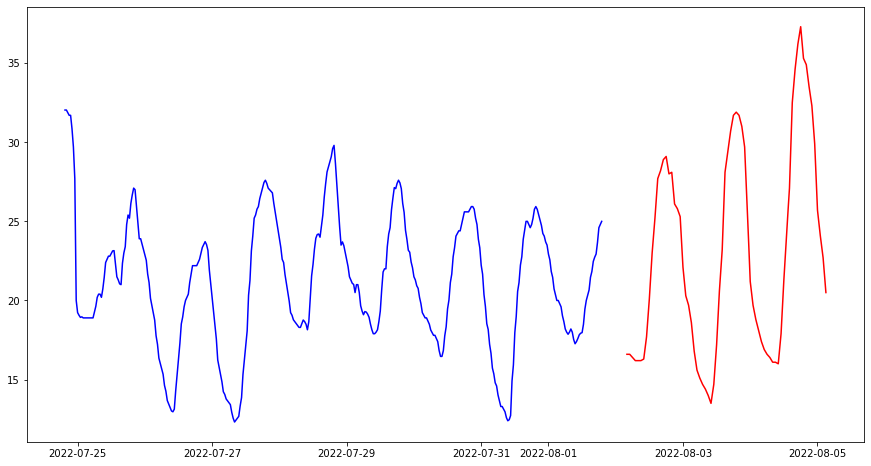

In [2]:
res = requests.get('https://api.weatherapi.com/v1/forecast.json?key={}&q=Callicoon, NY&days=3&aqi=no&alerts=no'.format(os.environ['WEATHER_KEY']))

forecast_raw = []
for day in res.json()['forecast']['forecastday']:
  forecast_raw += day['hour']

forecast = {}
for hour in forecast_raw:
  airtemp = hour['temp_c']
  cloudcover = hour['cloud'] * (4 / 100)
  precip = 0
  if (hour['will_it_rain']): precip = 2
  elif (hour['will_it_snow']): precip = 3

  forecast[pd.to_datetime(int(hour['time_epoch']), unit='s', origin='unix').tz_localize(None)] = {
    'airtemp': airtemp,
    'cloudcover': cloudcover,
    'precip': precip
  }

forecast_df = pd.DataFrame.from_dict(forecast, orient='index')

# add the last three days of historical observations to the prediction frame
# load observations df
observations = pd.read_pickle('output/observations.pickle')

last_three_days = observations.tail(4 * 24 * 4)
# last_three_days_actual = last_three_days['107338_00010']
last_three_days = last_three_days.drop(columns=['107337_00065'])
last_three_days = last_three_days.rename(columns={'107338_00010': 'y'})
last_three_days['ds'] = pd.to_datetime(last_three_days['ds']).dt.tz_convert(None)

# resample to 1h
last_three_days = last_three_days.set_index('ds')
last_three_days = last_three_days.resample('30min').interpolate('linear')
forecast_df = forecast_df.resample('30min').interpolate('linear')
last_three_days = last_three_days.reset_index()
forecast_df = forecast_df.reset_index()
last_three_days = last_three_days.rename(columns={'index': 'ds'})
forecast_df = forecast_df.rename(columns={'index': 'ds'})

# remove overlap between last three days and forecast df
forecast_df = forecast_df[~forecast_df['ds'].isin(last_three_days['ds'])]

print(last_three_days)
print(forecast_df)

plt.plot(last_three_days['ds'], last_three_days['airtemp'], color='blue', label='Actual')
plt.plot(forecast_df['ds'], forecast_df['airtemp'], color='red', label='Predicted')

# forecast_df = pd.concat((forecast_df.loc[forecast_df['ds'] > last_three_days['ds'].iat[-1]], last_three_days))
# print(forecast_df.head(), forecast_df.tail())

### Retrieve Model and Scaler

In [3]:
with open('src/model.pickle', 'rb') as f:
  model = pickle.load(f)

### Scale Forecast Data

In [4]:
# values = forecast_df.values
# values = values.astype('float')

# scaled = in_scaler.transform(values)

# input = pd.DataFrame(scaled, columns=['var1(t-1)', 'var2(t-1)', 'var3(t-1)'])
# test_X = input.values.reshape((input.shape[0], 1, input.shape[1]))
# print(test_X)

### Run Prediction

INFO - (NP.df_utils._infer_frequency) - Major frequency 30T corresponds to 99.74% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30min
WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/envs/prophet/lib/python3.9/site-packages/neuralprophet/forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency 30T corresponds to 99.583% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30min
INFO - (NP.df_utils._infer_frequency) - Major frequency 30T corresponds to 99.583% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30min
INFO - (NP.forecaster.__handle_missing_data) - 17 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - Detected y to

                     ds    airtemp  cloudcover  precip     y
0   2022-07-24 19:30:00  32.033333    0.000000     0.0  26.0
1   2022-07-24 20:00:00  32.033333    0.333333     0.0  26.2
2   2022-07-24 20:30:00  31.866667    0.666667     0.0  26.4
3   2022-07-24 21:00:00  31.700000    0.666667     0.0  26.5
4   2022-07-24 21:30:00  31.700000    0.333333     0.0  26.7
..                  ...        ...         ...     ...   ...
475 2022-08-04 01:30:00  19.250000    0.040000     0.0   NaN
476 2022-08-04 02:00:00  18.800000    0.080000     0.0   NaN
477 2022-08-04 02:30:00  18.450000    0.080000     0.0   NaN
478 2022-08-04 03:00:00  18.100000    0.080000     0.0   NaN
479 2022-08-04 03:30:00  17.750000    0.040000     0.0   NaN

[480 rows x 5 columns]


WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/envs/prophet/lib/python3.9/site-packages/neuralprophet/forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/anaconda3/envs/prophet/lib/python3.9/site-packages/neuralprophet/forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - /opt/homebrew/ana

                     ds     y yhat1 residual1 yhat2 residual2 yhat3 residual3  \
0   2022-07-24 19:30:00  26.0  None       NaN  None       NaN  None       NaN   
1   2022-07-24 20:00:00  26.2  None       NaN  None       NaN  None       NaN   
2   2022-07-24 20:30:00  26.4  None       NaN  None       NaN  None       NaN   
3   2022-07-24 21:00:00  26.5  None       NaN  None       NaN  None       NaN   
4   2022-07-24 21:30:00  26.7  None       NaN  None       NaN  None       NaN   
..                  ...   ...   ...       ...   ...       ...   ...       ...   
475 2022-08-03 17:00:00   NaN  None       NaN  None       NaN  None       NaN   
476 2022-08-03 17:30:00   NaN  None       NaN  None       NaN  None       NaN   
477 2022-08-03 18:00:00   NaN  None       NaN  None       NaN  None       NaN   
478 2022-08-03 18:30:00   NaN  None       NaN  None       NaN  None       NaN   
479 2022-08-03 19:00:00   NaN  None       NaN  None       NaN  None       NaN   

    yhat4 residual4  ...   

WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


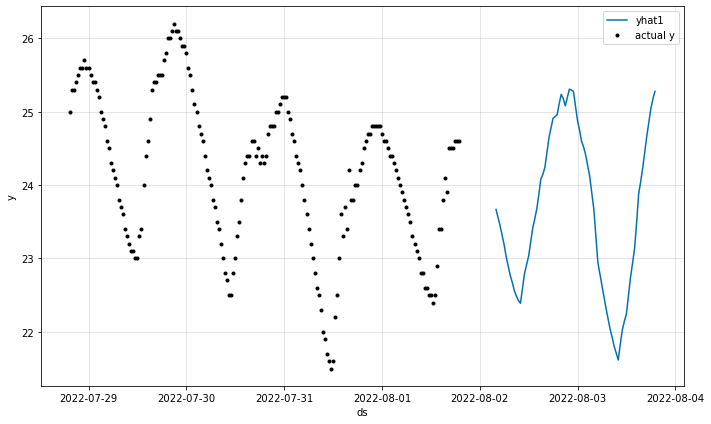

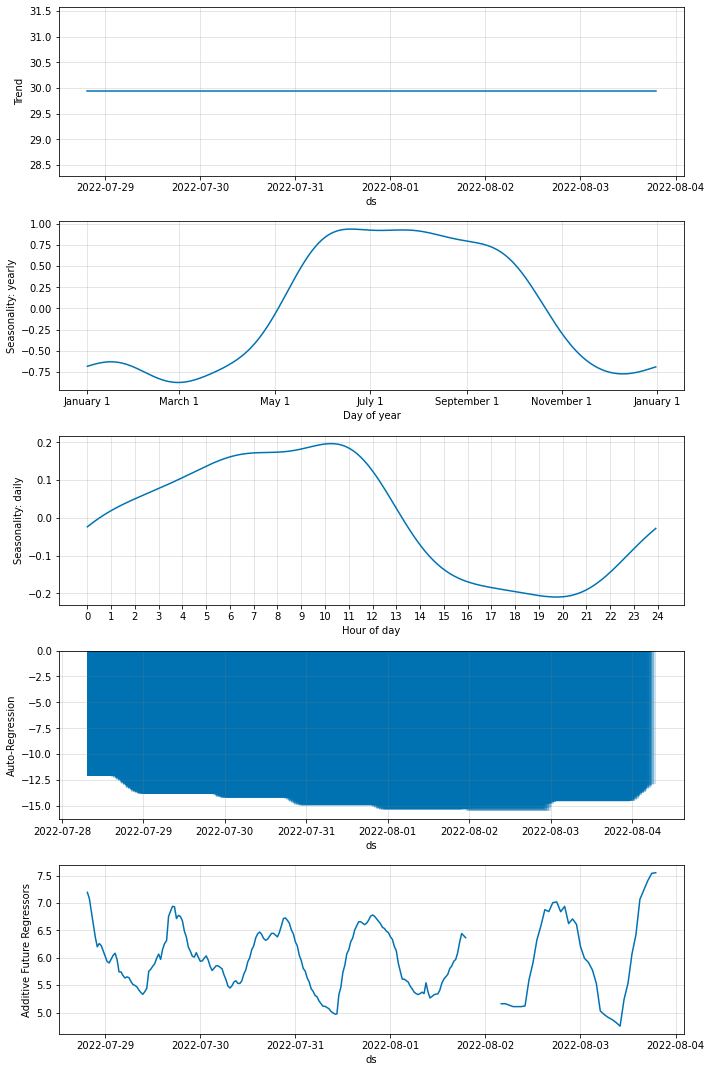

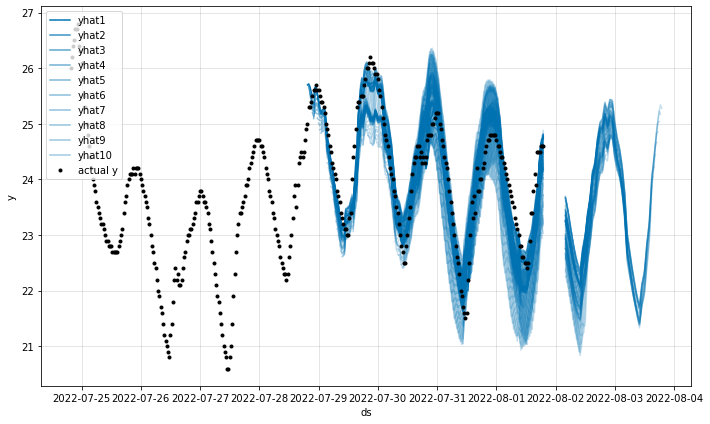

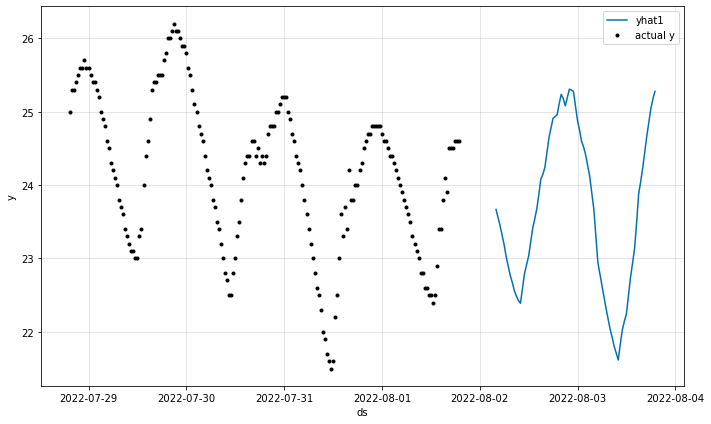

In [5]:
future = model.make_future_dataframe(
  df=last_three_days,
  regressors_df=forecast_df,
  n_historic_predictions=True
)
print(future)
pred = model.predict(future)
print(pred)

model.plot_components(pred)
model.plot(pred)
model.plot_last_forecast(pred)

# delta = last_three_days['y'].values - pred.iloc[:last_three_days.shape[0]]['yhat1'].values
# avg_delta = np.average(delta)
# pred_adjusted = pred['yhat1'].apply(lambda v: v + avg_delta)

# print(pred)

# plt.plot(pred['ds'], pred['yhat1'], color='blue')
# # plt.plot(pred['ds'], pred_adjusted, color='green')
# plt.plot(last_three_days['ds'], last_three_days['y'], color='black')
# # plt.fill_between(pred['ds'], pred['yhat_lower'], pred['yhat_upper'], color='blue', alpha=0.15)
# plt.show()

# model.plot_components(pred)